# SPARK SQL (CLOUDS Fall 2018)

In this notebook, we will learn how to use the DataFrame API and SparkSQL to perform simple data analytics tasks.

# Goals
The main goals of this notebook are the following:
1. Understand the advantages and disadvantages of using DataFrame over RDD
2. Analyze the airline data with the DataFrame API and SparkSQL

# Steps

- First, in section 1, we will go through a short introduction about the DataFrame API with a small example to see how can we use it and how it compares to the low-level RDD abstraction.
- In section 2, we delve into the details of the use case of this notebook including: providing the context, introducing the data
- In section 3, we perform data exploration and analysis

# 1. RDD and DataFrame APIs

In our previous notebooks, we have worked with RDDs (Resilient Distributed Dataset), the basic abstraction in Spark. The main reason is due to the task at hand: we have been invovled in the design of distributed algorithms.

In this laboratory session, we study (or revisit) the DataFrame API - an immutable distributed collection of data.
DataFrames allow developers to impose a **structure** on a distributed collection of data, allowing higher-level abstraction; in addition, DataFrames provide a domain specific language (DSL) API to manipulate distributed, structured data. Ultimately, the goal is to make Spark accessible to a wider audience, beyond researchers and specialized data engineers.

Let's take a small example to see the difference between RDDs and DataFrames. The two cells below contain short code snippets that perform the same task: count the frequency of words in a document, then sort the result in descending order. The first snippet is the same you have been working on in the very [first notebook](https://github.com/EURECOM-CLOUDS-COURSE/Introduction/blob/master/introduction-lab.ipynb) of the CLOUDS course.
The second code snippet uses the DataFrame API.

<div class="alert alert-block alert-info">

<strong>Question 1.</strong> 

Run both approaches (RDD and DataFrame) detailed below, compare their runtime, and discuss. Is the DataFrame API approach faster? Can you explain why?

</div>

In [1]:
import time
time_start = time.time()
words = (
            # read the text file
            sc.textFile("/datasets/gutenberg/gutenberg_small.txt").repartition(16)
            
            # construct words from lines
            .flatMap(lambda line: line.split())
            
            # map each word to (word, 1)
            .map(lambda x: (x, 1))
    
            # reduce by key: accumulate sum the freq of the same word
            .reduceByKey(lambda freq1, freq2: freq1 + freq2)
            
            # swap (word, freq) to (freq, word)
            .map(lambda x: (x[1], x[0]))
    
            # sort result by key DESC
            .sortByKey(False)
         )
print("Runtime: %.2f sec" % (time.time() - time_start))
print(words.take(5))

Runtime: 165.04 sec
[(29556020, 'the'), (18043957, 'of'), (14914748, 'and'), (12892052, 'to'), (9779124, 'a')]


In [2]:
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import explode, split, desc
sqlContext = SQLContext(sc)
time_start = time.time()

# read the text file
df = sqlContext.read.text("/datasets/gutenberg/gutenberg_small.txt")

# show 3 samples
# df.show(3)

result = (
    # split into words
    df.select(explode(split(df.value, "\s+|\t+")).alias('word'))
    
    # group by each word
    .groupBy(['word'])
    
    # count the freq
    .count()
    
    # sort the result
    .orderBy(desc("count"))
)

result.show(5)
print("Runtime: %.2f sec" % (time.time() - time_start))

+----+--------+
|word|   count|
+----+--------+
| the|29556020|
|  of|18043957|
|    |16611988|
| and|14914748|
|  to|12892052|
+----+--------+
only showing top 5 rows

Runtime: 115.64 sec


Answer 1: The dataframe API approach is faster. The data is structured so we can use dataframe, it is faster because optimization can take place (in particular, catalyst optimizer is used)

# 2. Analysis of flight data using the DataFrame API and SparkSQL

## Use case

In this notebook, we play the role of a data scientist working in the travel industry, specifically on air transportation of passengers. We want to explore the data collected by the Department of Transportation (DoT) to understand passengers' behavior, as well as the properties of all flights, across several airline companies.

The dataset provided by the DoT has 29 features, that can be either categorical or numerical. For example, the ```src_airport``` (source airport) is categorical: there exist no comparison operator between airport names. We can not say "SGN is bigger than NCE". The ```departure_time``` feature is numerical, for which a comparison operator exists. For instance, "flight departing before 6PM" can be express by "departure_time < 1800".

In this use case, most features are numerical, except carrier, flight_number, cancelled, cancelation_code and diverted. 
The data contains a header, that is useless when analyzing the data: it serves the purpose of an "embedded schema", to help data scientist figure out what information is available. Note that there are some features with missing values in some lines of the dataset. The missing values are marked by "NA". These values can cause problems when processing the data and can lead to unexpected results. Therefore, we need to remove the header and replace all "NA" values by empty values, such as they can be interpreted as null values.

## DataFrame
As we have seen already, there are multiple ways to manipulate data:

- Using the RDD abstraction

- Using the DataFrame abstraction. 

A DataFrame is a distributed collection of data organized into named columns. It is based on the data frame concept in R language or in Pandas for Python. In some sense, it is similar to a table in a relational database: each item is a list of values (the columns). Also, the value in each row of each column can be accessed by the column's name.

To use DataFrames, the data should be clean (no invalid values). That means we cannot create DataFrame directly from the "RAW" data. Instead, we will first create an RDD from RAW data, produce a new, clean RDD, then transform it to a DataFrame and work on it. The RDD `cleaned_data` is an `RDD[String]`. We need to transform it to `RDD[(TypeOfColumn1, TypeOfColumn2, ..., TypeOfColumn29)]` then call a function to create a DataFrame from the new RDD. Please note that, package `com.databricks.spark.csv` can really help us to load the data efficiently without concerns about parsing, conversions, etc... However, the CSV package can have some problems when loading not well-formatted data or the data that has many kinds of missing values. The guidelines defined this notebook are a general way to help you work with any data.


DataFrames can be constructed from a wide array of sources such as: structured data files, tables in Hive, external databases, or existing RDDs.

During the labs in this course, we will mainly work with CSV data files. So, in the next sections, we only focus on constructing dataframes from structured data files directly and from existing RDD.

### Constructing a DataFrame directly from structured data file

To construct DataFrame from a structured file directly, the file type must be supported. Currently, Spark supports csv, json, avro and many more. Among these types, the csv type is one of the most popular in data analytics. A DataFrame is constructed from csv files by using the package spark-csv from Databricks.


In [3]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

df = sqlContext.read.load('/datasets/airline/1994.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)

Using the function load parametrized with `com.databricks.spark.csv`, we ask the SqlContext to use the parser from the DataBricks package. Additionally, we can specify whether the file has a header, or ask the parser to guess the data type of columns automatically. The parsed data types is viewed using the function printSchema.

In [4]:
# print(df.dtypes)
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |

As you can see, the automatically inferred data types are **not** as expected. For example, we expect that `CRSDepTime` to be of interger type. The type and the name of each column can be modified using function ```withColumn``` and ```withColumnRename``` respectively. Additionally, we can also compute and print basic descriptive statistics of numerical columns via the function ```describe``` (similar to Pandas).

In [5]:
df = (df
          # change type of column CRSDepTime by casting its values to interger type
          .withColumn('CRSDepTime', df.CRSDepTime.cast('int'))

          # rename the column
          .withColumnRenamed('CRSDepTime', 'scheduled_departure_time')
    )

# print schema of the current data
df.printSchema()

# run jobs to calculate basic statistic information and show it
df.describe().show()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nulla

### Constructing a DataFrame from an existing RDD

Another way to construct a DataFrame is using data from an existing RDD. The main advantage of this approach is that it does not need a third party library. However, with this method, we have to remove the header ourself and provide a clear schema.



In [6]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import explode, split, desc, col, udf, round
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
import seaborn as sns

sqlContext = SQLContext(sc)

data = sc.textFile('/datasets/airline/1994.csv')

# extract the header
header = data.first()

# replace invalid data with NULL and remove header
cleaned_data = (
        data
    
        # filter out the header
        .filter(lambda line: line != header)
    
         # replace the 'missing data' by empty value
        .map(lambda line: ','.join(list(map(lambda x: x if x != 'NA' else '',line.split(',')))))
    )

airline_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("year",                     IntegerType(), True), \
    StructField("month",                    IntegerType(), True), \
    StructField("day_of_month",             IntegerType(), True), \
    StructField("day_of_week",              IntegerType(), True), \
    StructField("departure_time",           IntegerType(), True), \
    StructField("scheduled_departure_time", IntegerType(), True), \
    StructField("arrival_time",             IntegerType(), True), \
    StructField("scheduled_arrival_time",   IntegerType(), True), \
    StructField("carrier",                  StringType(),  True), \
    StructField("flight_number",            StringType(),  True), \
    StructField("tail_number",              StringType(),  True), \
    StructField("actual_elapsed_time",      IntegerType(), True), \
    StructField("scheduled_elapsed_time",   IntegerType(), True), \
    StructField("air_time",                 IntegerType(), True), \
    StructField("arrival_delay",            IntegerType(), True), \
    StructField("departure_delay",          IntegerType(), True), \
    StructField("src_airport",              StringType(),  True), \
    StructField("dest_airport",             StringType(),  True), \
    StructField("distance",                 IntegerType(), True), \
    StructField("taxi_in_time",             IntegerType(), True), \
    StructField("taxi_out_time",            IntegerType(), True), \
    StructField("cancelled",                StringType(),  True), \
    StructField("cancellation_code",        StringType(),  True), \
    StructField("diverted",                 StringType(),  True), \
    StructField("carrier_delay",            IntegerType(), True), \
    StructField("weather_delay",            IntegerType(), True), \
    StructField("nas_delay",                IntegerType(), True), \
    StructField("security_delay",           IntegerType(), True), \
    StructField("late_aircraft_delay",      IntegerType(), True)\
])

In [7]:
# convert each line into a tuple of features (columns) with the corresponding data type
cleaned_data_to_columns = (
    cleaned_data.map(lambda l: l.split(","))
    .map(lambda cols: 
         (
            int(cols[0])  if cols[ 0] else None,
            int(cols[1])  if cols[ 1] else None,
            int(cols[2])  if cols[ 2] else None,
            int(cols[3])  if cols[ 3] else None,
            int(cols[4])  if cols[ 4] else None,
            int(cols[5])  if cols[ 5] else None,
            int(cols[6])  if cols[ 6] else None,
            int(cols[7])  if cols[ 7] else None,
            cols[8]       if cols[ 8] else None,
            cols[9]       if cols[ 9] else None,
            cols[10]      if cols[10] else None,
            int(cols[11]) if cols[11] else None,
            int(cols[12]) if cols[12] else None,
            int(cols[13]) if cols[13] else None,
            int(cols[14]) if cols[14] else None,
            int(cols[15]) if cols[15] else None,
            cols[16]      if cols[16] else None,
            cols[17]      if cols[17] else None,
            int(cols[18]) if cols[18] else None,
            int(cols[19]) if cols[19] else None,
            int(cols[20]) if cols[20] else None,
            cols[21]      if cols[21] else None,
            cols[22]      if cols[22] else None,
            cols[23]      if cols[23] else None,
            int(cols[24]) if cols[24] else None,
            int(cols[25]) if cols[25] else None,
            int(cols[26]) if cols[26] else None,
            int(cols[27]) if cols[27] else None,
            int(cols[28]) if cols[28] else None
         ))             
)
    
# create dataframe
df = sqlContext.createDataFrame(cleaned_data_to_columns, airline_data_schema)\
    .select(['year', 'month', 'day_of_month', 'day_of_week',
            'scheduled_departure_time','scheduled_arrival_time',
            'arrival_delay', 'distance', 
            'src_airport', 'dest_airport', 'carrier'])\
    .cache()

### Examples

Using the contructed DataFrame, we can answer some simple questions:

<ul>
<li>How many night flights do we have in our data?</li>
<li>How many night flights per unique carrier?</li>
</ul>

<strong>NOTE:</strong> We define "night" to start at 6pm.

In [8]:
df[df.scheduled_departure_time > 1800].count()

1078203

In [9]:
df[df.scheduled_departure_time > 1800].groupBy(df.carrier).count().orderBy('count', ascending=0).collect()

[Row(carrier='DL', count=208224),
 Row(carrier='US', count=170397),
 Row(carrier='AA', count=142832),
 Row(carrier='WN', count=124024),
 Row(carrier='UA', count=113640),
 Row(carrier='NW', count=100453),
 Row(carrier='CO', count=94501),
 Row(carrier='TW', count=54771),
 Row(carrier='HP', count=44351),
 Row(carrier='AS', count=25010)]

# 3. Data exploration
Next, we will go over a series of simple queries on our data, to perform exploration and compute statistics using the DataFrame API and SparkSQL. These queries directly map to the questions you need to answer. 

**NOTE:** finding the right question to ask is difficult! Don't be afraid to complement the questions below, with your own questions that, in your opinion, are valuable ways to inspect data. This can give you extra points!

- Basic queries:
  - How many unique origin airports?
  - How many unique destination airports?
  - How many carriers?
  - How many flights that have a scheduled departure time later than 18h00?
  
  **My additions below**
  - How many unique airports ? (including both origin and destination)
  - How many delayed flights ?
  - From which interval of time the data were collected ?
  - How many flights have a distance greater than a certain threshold ?


- Statistics on flight volume: this kind of statistics are helpful to reason about delays. Indeed, it is plausible to assume that "*the more flights in an airport, the higher the probability of delay*".
  - How many flights in each month of the year?
  - Is there any relationship between the number of flights and the days of week?
  - How many flights in different days of months and in different hours of days?
  - Which are the top 20 busiest airports (this depends on inbound and outbound traffic)?
  - Which are the top 20 busiest carriers?
  
  **My additions below**
  - How many flights per carrier ?
  - Which is the mean delay of a flight ?
  - Which is the mean delay per carrier ?
  - Which is the mean delay per destination airport ? (This could be useful to understand which are the airports that have problems in handling traffic)


- Statistics on the fraction of delayed flights
  - What is the percentage of delayed flights (over total flights) for different hours of the day?
  - Which hours of the day are characterized by the longest flight delay?
  - What are the fluctuation of the percentage of delayed flights over different time granularities?
  - What is the percentage of delayed flights which depart from one of the top 20 busiest airports?
  - What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?
  
  **My additions below**
  - What is the percentage of delayed flights during working days ?
  - What is the percentage of delayed flights during weekends ?
  - What is the percentage of delayed flights that has a distance greater than X kms ? (Useful to understand if longer flights are correlated with an higher delay, maybe due to the fact that a plane will go through different weather conditions along the way)

## Question 2: Basic queries

### Question 2.1
<div class="alert alert-info">

How many origin airports? How many destination airports? Discuss the results, indicating any discrepancies or strange facts about the data.

</div>

In [10]:
# How many (unique) origin airports ?
origin_airports_df = df.select("src_airport").distinct().withColumnRenamed("src_airport","airport").cache()
print(f'Origin airports are {origin_airports_df.count()}')

Origin airports are 224


In [11]:
# How many (unique) destination airports ?
destination_airports_df = df.select("dest_airport").distinct().withColumnRenamed("dest_airport","airport").cache()
print(f'Destination airports are {destination_airports_df.count()}')

Destination airports are 225


These values show us that there are 224 origin airports and 225 destination airports. Despite not being so many airports, it is a good number; the strange fact is that there is an airport that is present among the destination airports only (assuming that all the 224 origin airports are also in the destination airports, but we should inspect it for further analysis on this fact)

### Question 2.2

<div class="alert alert-info">
How many unique carriers are present in the data?
</div>

In [12]:
# How many unique carriers ?
print(f'Unique carriers are {df.select("carrier").distinct().count()}')

Unique carriers are 10


### Question 2.3

<div class="alert alert-info">
<ul>
<li>How many night flights (that is, flights departing later than 6pm or earlier than 6am)?</li>
<li>What is the percentage of night flights over the total volume of flights</li>
</ul>

<br>
<br>
<strong>NOTE:</strong> Here we're using a more refined definition of what is a night flight, than in our earlier examples.

</div>

In [13]:
# How many night flights (departing before 6AM --> 600 or later than 6PM --> 1800)
tot_night_flights = df.filter("scheduled_departure_time<600 or scheduled_departure_time>1800").count()
print(f'There are {tot_night_flights} night flights')

There are 1121918 night flights


In [14]:
# What is the percentage of night flights over the total volume of flights ?
print ('The percentage of night flights is: %.2f' % (tot_night_flights / df.count() * 100) + ' %')

The percentage of night flights is: 21.66 %


## Question 3: Flight volume statistics

### Question 3.1: 

<div class="alert alert-info">
How many flights in each month of the year? Plot the changes over months by a line chart and comment the figure.

<br>
From the result, we can learn the dynamics of flight volume over months. For example, if we only consider flights in 1994 (to start, it's always better to focus on smaller amount of data), we can discuss about which months are most likely to have flights experiencing delays.
</div>


In [15]:
# How many flights in each month of the year
month_flights_df = df.groupBy("month").count().withColumnRenamed("count","flights").sort("month").cache()
month_flights_df.show()

+-----+-------+
|month|flights|
+-----+-------+
|    1| 423861|
|    2| 386954|
|    3| 435516|
|    4| 420995|
|    5| 436432|
|    6| 426490|
|    7| 443736|
|    8| 451086|
|    9| 430861|
|   10| 449369|
|   11| 428227|
|   12| 446521|
+-----+-------+



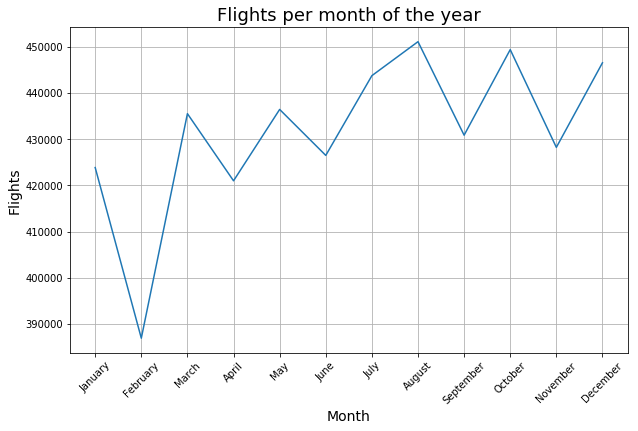

In [16]:
# Plot flights in each month of the year
import seaborn as sns

index_month = {1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June", 7:"July", 8:"August", 9:"September", 10:"October", 11:"November", 12:"December"}
month_flights_pandas_df = month_flights_df.toPandas()
month_flights_pandas_df.replace({"month": index_month}, inplace=True)
plt.figure(figsize=(10,6))
plt.title("Flights per month of the year",fontsize=18)
plt.grid()
sns.lineplot(x="month", y="flights", data=month_flights_pandas_df, sort=False)
plt.xlabel("Month",fontsize=14)
plt.ylabel("Flights", fontsize=14)
plt.xticks(rotation=45)
plt.show()

From the chart we can clearly see that peak number of flights is on August (where the majority of people is on holidays) and in general that the number of flights in the second half of the year is higher than the first half (especially in July, August, October and December). It's interesting to notice how October has an high number of flights, despite there is no particular festivity like Christmas in December, or holidays like July and August.

In [17]:
# Consider only year 1994 (not useful since the data are about 1994) - just for completeness
flights_1994_df = df.filter("year==1994")
# Remove lines where arrival_delay is null
flights_1994_no_null_df = flights_1994_df.filter("arrival_delay is not NULL")
# Grouping by month, calculating average delay per flight in each month
month_avgDelay_1994_df = flights_1994_no_null_df.groupBy("month").avg("arrival_delay").sort("month")
month_avgDelay_1994_df.show()

+-----+------------------+
|month|avg(arrival_delay)|
+-----+------------------+
|    1|10.700433047042505|
|    2|  9.21163894842508|
|    3| 4.509724110951733|
|    4|5.3110195501970345|
|    5|2.3457444235327722|
|    6| 6.609869842253827|
|    7| 7.877674453596449|
|    8| 5.211512636774567|
|    9|2.0335722685781485|
|   10|3.4944407362776677|
|   11| 5.577380756172331|
|   12| 5.978600390278839|
+-----+------------------+



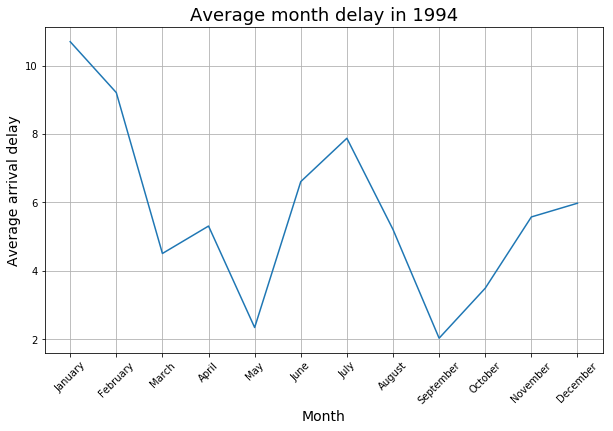

In [18]:
# Plot it
month_avgDelay_1994_pandas_df = month_avgDelay_1994_df.toPandas()
month_avgDelay_1994_pandas_df.replace({"month": index_month}, inplace=True)
plt.figure(figsize=(10,6))
plt.title("Average month delay in 1994", fontsize=18)
plt.grid()
sns.lineplot(x="month", y="avg(arrival_delay)", data=month_avgDelay_1994_pandas_df, sort=False)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Average arrival delay", fontsize=14)
plt.xticks(rotation=45)
plt.show()

From this chart we can see that in 1994 January and February were the months with the highest average arrival delay, followed by July. This could be linked to the post Christmas holidays in January (many people taking planes: a lot of traffic) and to holidays in July. Data about February are a little bit stranger, but we may suppose that, being a winter's month, flights could experience bad weather conditions and so delays.

### Question 3.2: 

<div class="alert alert-info">
Is there any relationship between the number of flights and the days of the week?  

Plot a bar chart and interpret the figure.

<br>
<br>
<strong>NOTE:</strong> You should study both global aggregates (irrespectively of the month of the year), and monthly aggregates (day statistics, for each different month of the year).

<br>
<br>
By answering this question, we could learn about the importance of the weekend/weekday feature for our predictive task.
</div>

In [19]:
# First, we will inspect the data irrespectively of the month of the year
weekday_numberFlights_df = df.groupBy("day_of_week").count().withColumnRenamed("count","flights").sort("day_of_week").cache()
weekday_numberFlights_df.show()

+-----------+-------+
|day_of_week|flights|
+-----------+-------+
|          1| 754636|
|          2| 756532|
|          3| 756864|
|          4| 751537|
|          5| 751531|
|          6| 695245|
|          7| 713703|
+-----------+-------+



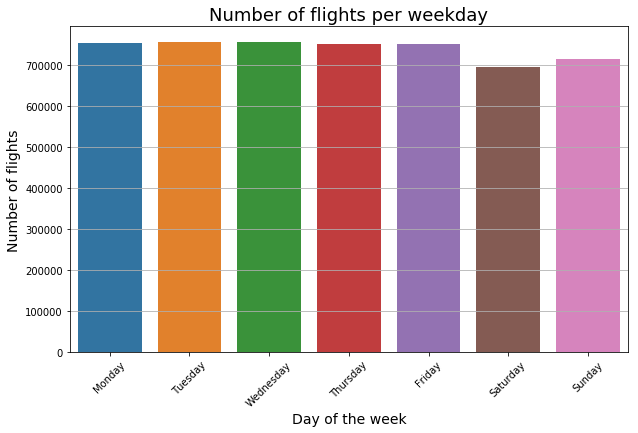

In [20]:
# Plot it
index_day_of_week = {1:"Monday", 2:"Tuesday", 3:"Wednesday", 4:"Thursday", 5:"Friday", 6:"Saturday", 7:"Sunday"}
weekday_numberFlights_pandas_df = weekday_numberFlights_df.toPandas()
weekday_numberFlights_pandas_df.replace({"day_of_week": index_day_of_week}, inplace=True)
plt.figure(figsize=(10,6))
plt.title("Number of flights per weekday", fontsize=18)
plt.grid()
sns.barplot(x="day_of_week", y="flights", data=weekday_numberFlights_pandas_df)
plt.xlabel("Day of the week", fontsize=14)
plt.ylabel("Number of flights", fontsize=14)
plt.xticks(rotation=45)
plt.show()

Here we notice how the weekend days are the less busy ones as number of flights. At first sight this could appear strange, but if we consider that:
- In general the price of a ticket is higher during weekend
- People going go on holiday they usually take breaks of 1+ weeks and so there are no constraint on which day they should depart
- People taking work's flight these are more used to do that during working days

Then we can understand why this is the result of the analysis. However, we should go deeper in our analysis looking at how these numbers change considering a specific month.

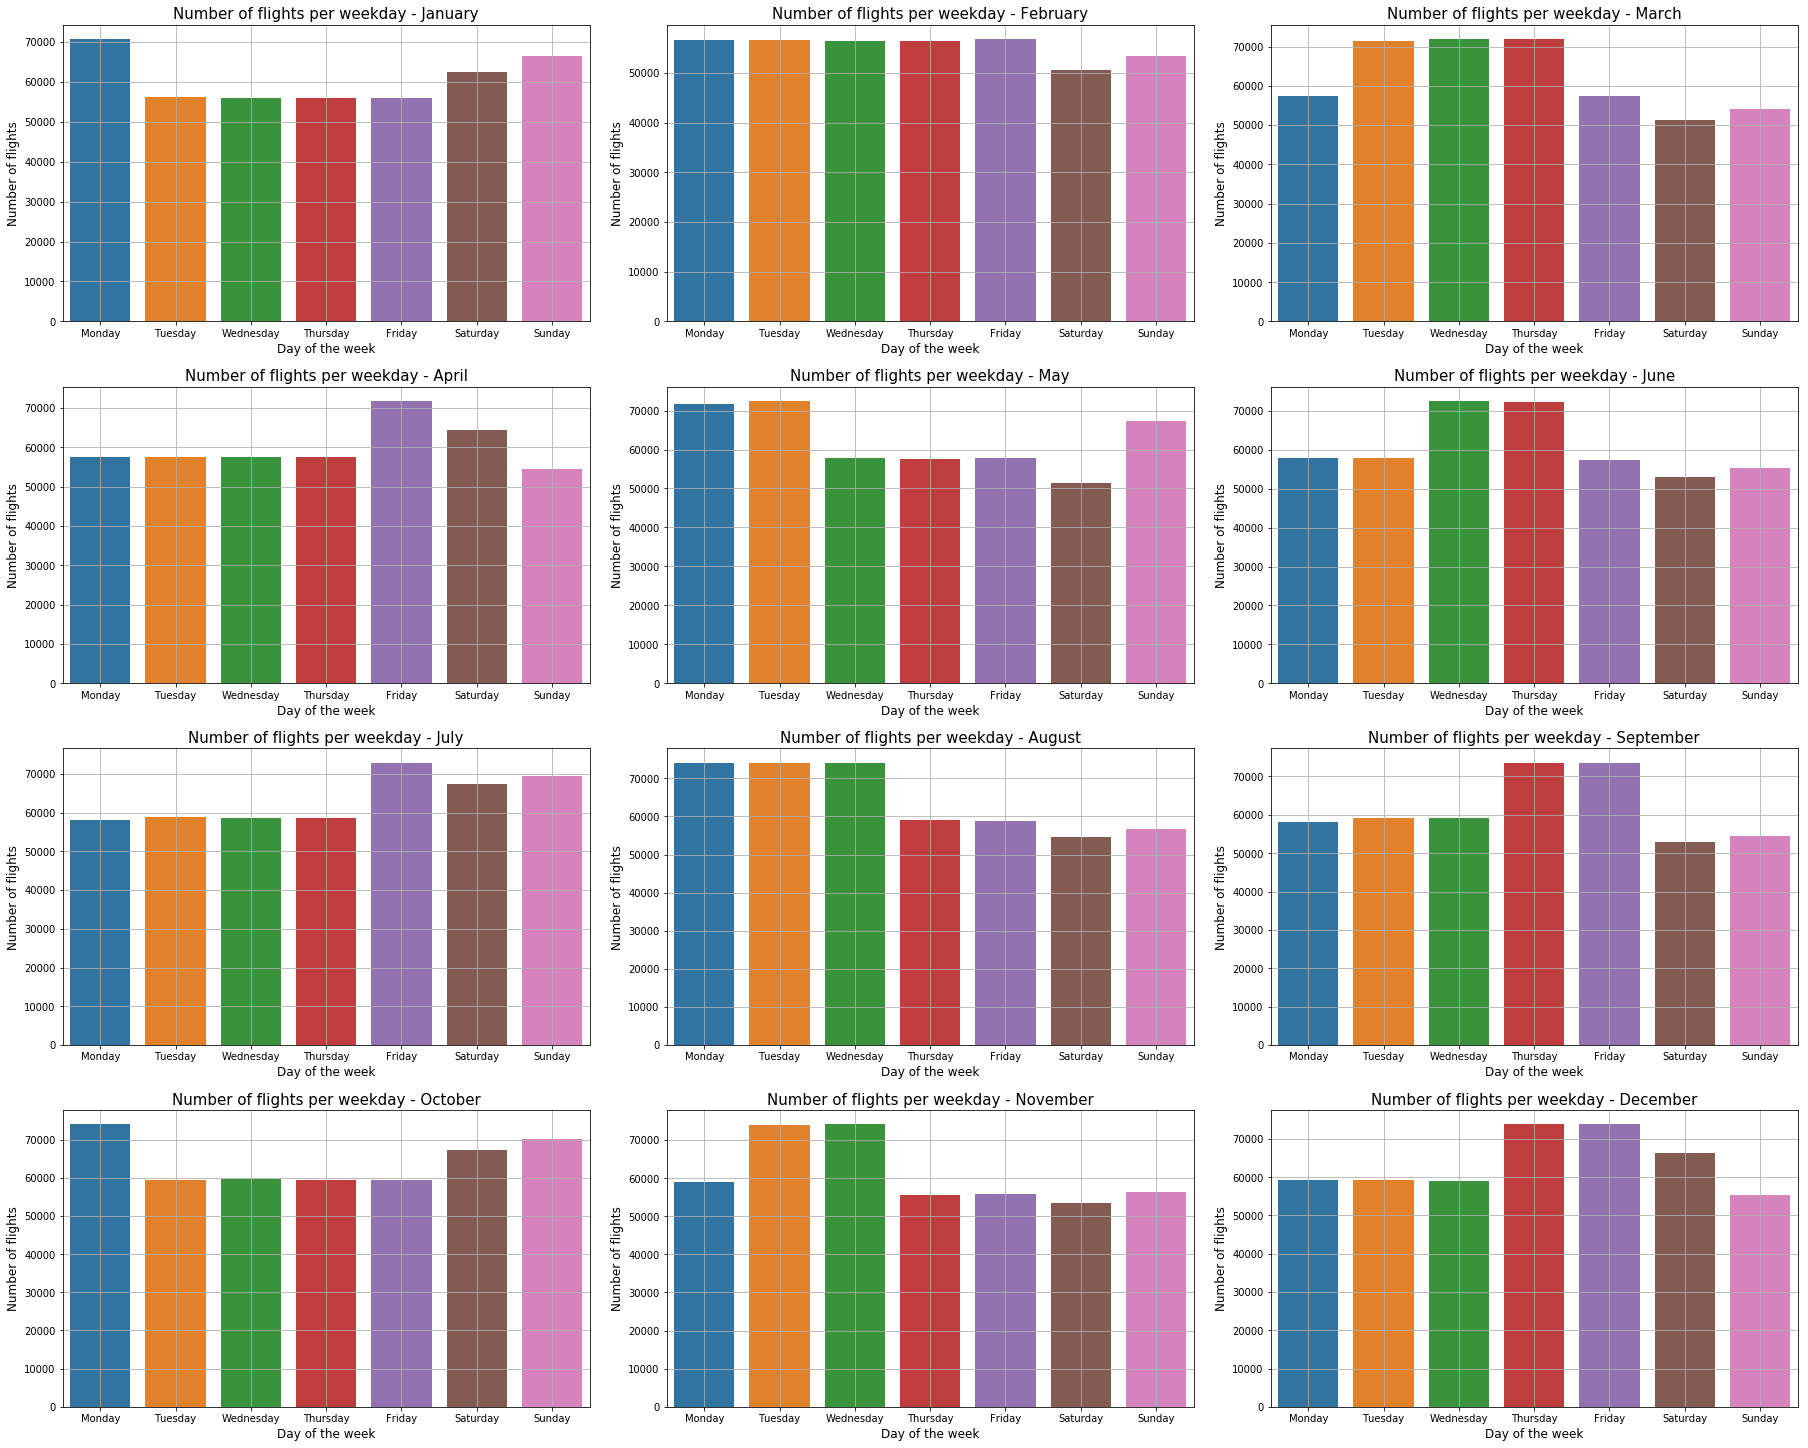

In [21]:
plt.rcParams['figure.constrained_layout.use'] = True
fig,axes = plt.subplots(4,3, figsize=(25,20))
for x in range(4):
    for y in range(3):
        weekday_numberFlights_pandas_df = df.filter(f"month=={3*x + y + 1}").groupBy("day_of_week").count().sort("day_of_week").toPandas()
        weekday_numberFlights_pandas_df.replace({"day_of_week": index_day_of_week}, inplace=True)
        sns.barplot(ax=axes[x,y], x="day_of_week", y="count", data=weekday_numberFlights_pandas_df)
        axes[x,y].grid()
        axes[x,y].set_title(f"Number of flights per weekday - {index_month[3*x + y + 1]}", fontsize=15)
        axes[x,y].set_xlabel("Day of the week", fontsize=12)
        axes[x,y].set_ylabel("Number of flights", fontsize=12)

From these charts we can see that the distribution of flights during the weekdays changes over the months; in particular there are months such as January, July and October which have an high number of flights during weekend, while other months flights' distributions show higher numbers during the weekday. Thanks to this analysis we can see how the previous general chart was not enough to fully understand the situation between day of the week and number of flights; we should also consider the specific month.

### Question 3.3

<div class="alert alert-info">
How many flights in different days of months and in different hours of days?  
<br>
<br>

<strong>NOTE:</strong> Similarly to the previous note, you need to compute both global statistcs and monthly statistics.

<br>
<br>
Plot  bar charts, and interpret your figures.
</div>

## Days of months

In [22]:
# First, we will inspect the data irrespectively of the month of the year
monthday_numberFlights_df = df.groupBy("day_of_month").count().withColumnRenamed("count","flights").sort("day_of_month").cache()
monthday_numberFlights_df.show(31)

+------------+-------+
|day_of_month|flights|
+------------+-------+
|           1| 169674|
|           2| 169829|
|           3| 168678|
|           4| 169399|
|           5| 168423|
|           6| 170650|
|           7| 172210|
|           8| 170674|
|           9| 170077|
|          10| 170252|
|          11| 172362|
|          12| 169542|
|          13| 171230|
|          14| 172081|
|          15| 170737|
|          16| 169985|
|          17| 170132|
|          18| 171868|
|          19| 169483|
|          20| 171142|
|          21| 172283|
|          22| 171305|
|          23| 170695|
|          24| 166379|
|          25| 167435|
|          26| 168767|
|          27| 171222|
|          28| 171760|
|          29| 155695|
|          30| 155915|
|          31| 100164|
+------------+-------+



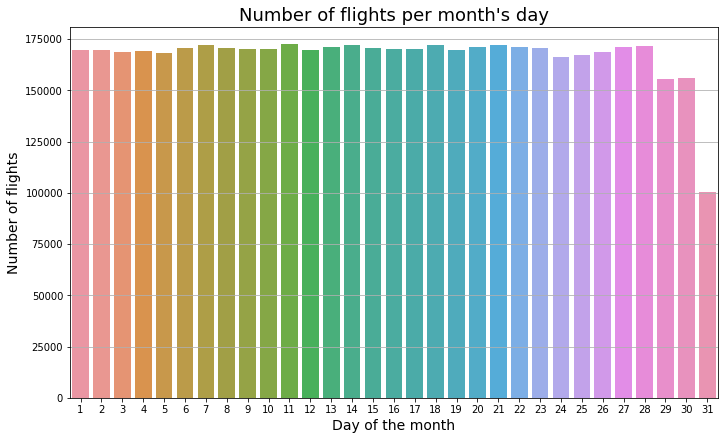

In [23]:
# Plot it
monthday_numberFlights_pandas_df = monthday_numberFlights_df.toPandas()
plt.figure(figsize=(10,6))
plt.title("Number of flights per month's day", fontsize=18)
plt.grid()
sns.barplot(x="day_of_month", y="flights", data=monthday_numberFlights_pandas_df)
plt.xlabel("Day of the month", fontsize=14)
plt.ylabel("Number of flights", fontsize=14)
plt.show()

Here we have to underline that lower values on 29th, 30th and 31th day are due to the fact that the months of the year have different length and so not all the months have a 29th, 30th and 31th day. In addition here it would be useful to use lineplot to have a visualization that could show us better the difference between days (barplot starts from 0 for data visualization proportion rules, while with lineplots charts not starting from 0 are allowed, which is useful here). For the sake of completeness I reported below (I removed last 3 days to focus on the general trend, knowing that last 3 days have lower values) :

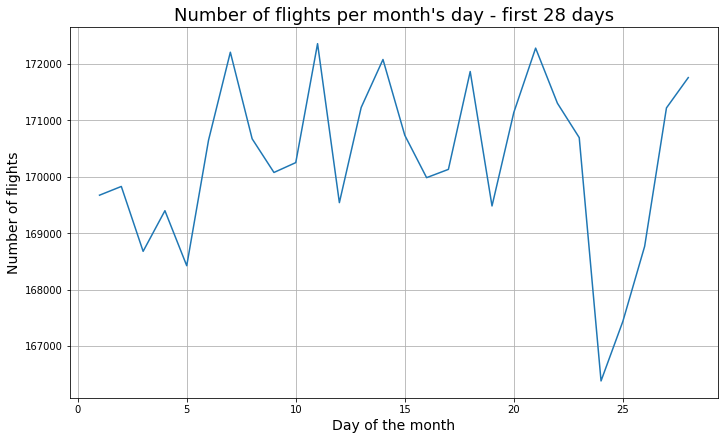

In [24]:
monthday_numberFlights_pandas_df = monthday_numberFlights_df.filter("day_of_month != 29 and day_of_month != 30 and day_of_month != 31").toPandas()
plt.figure(figsize=(10,6))
plt.title("Number of flights per month's day - first 28 days", fontsize=18)
plt.grid()
sns.lineplot(x="day_of_month", y="flights", data=monthday_numberFlights_pandas_df)
plt.xlabel("Day of the month", fontsize=14)
plt.ylabel("Number of flights", fontsize=14)
plt.show()

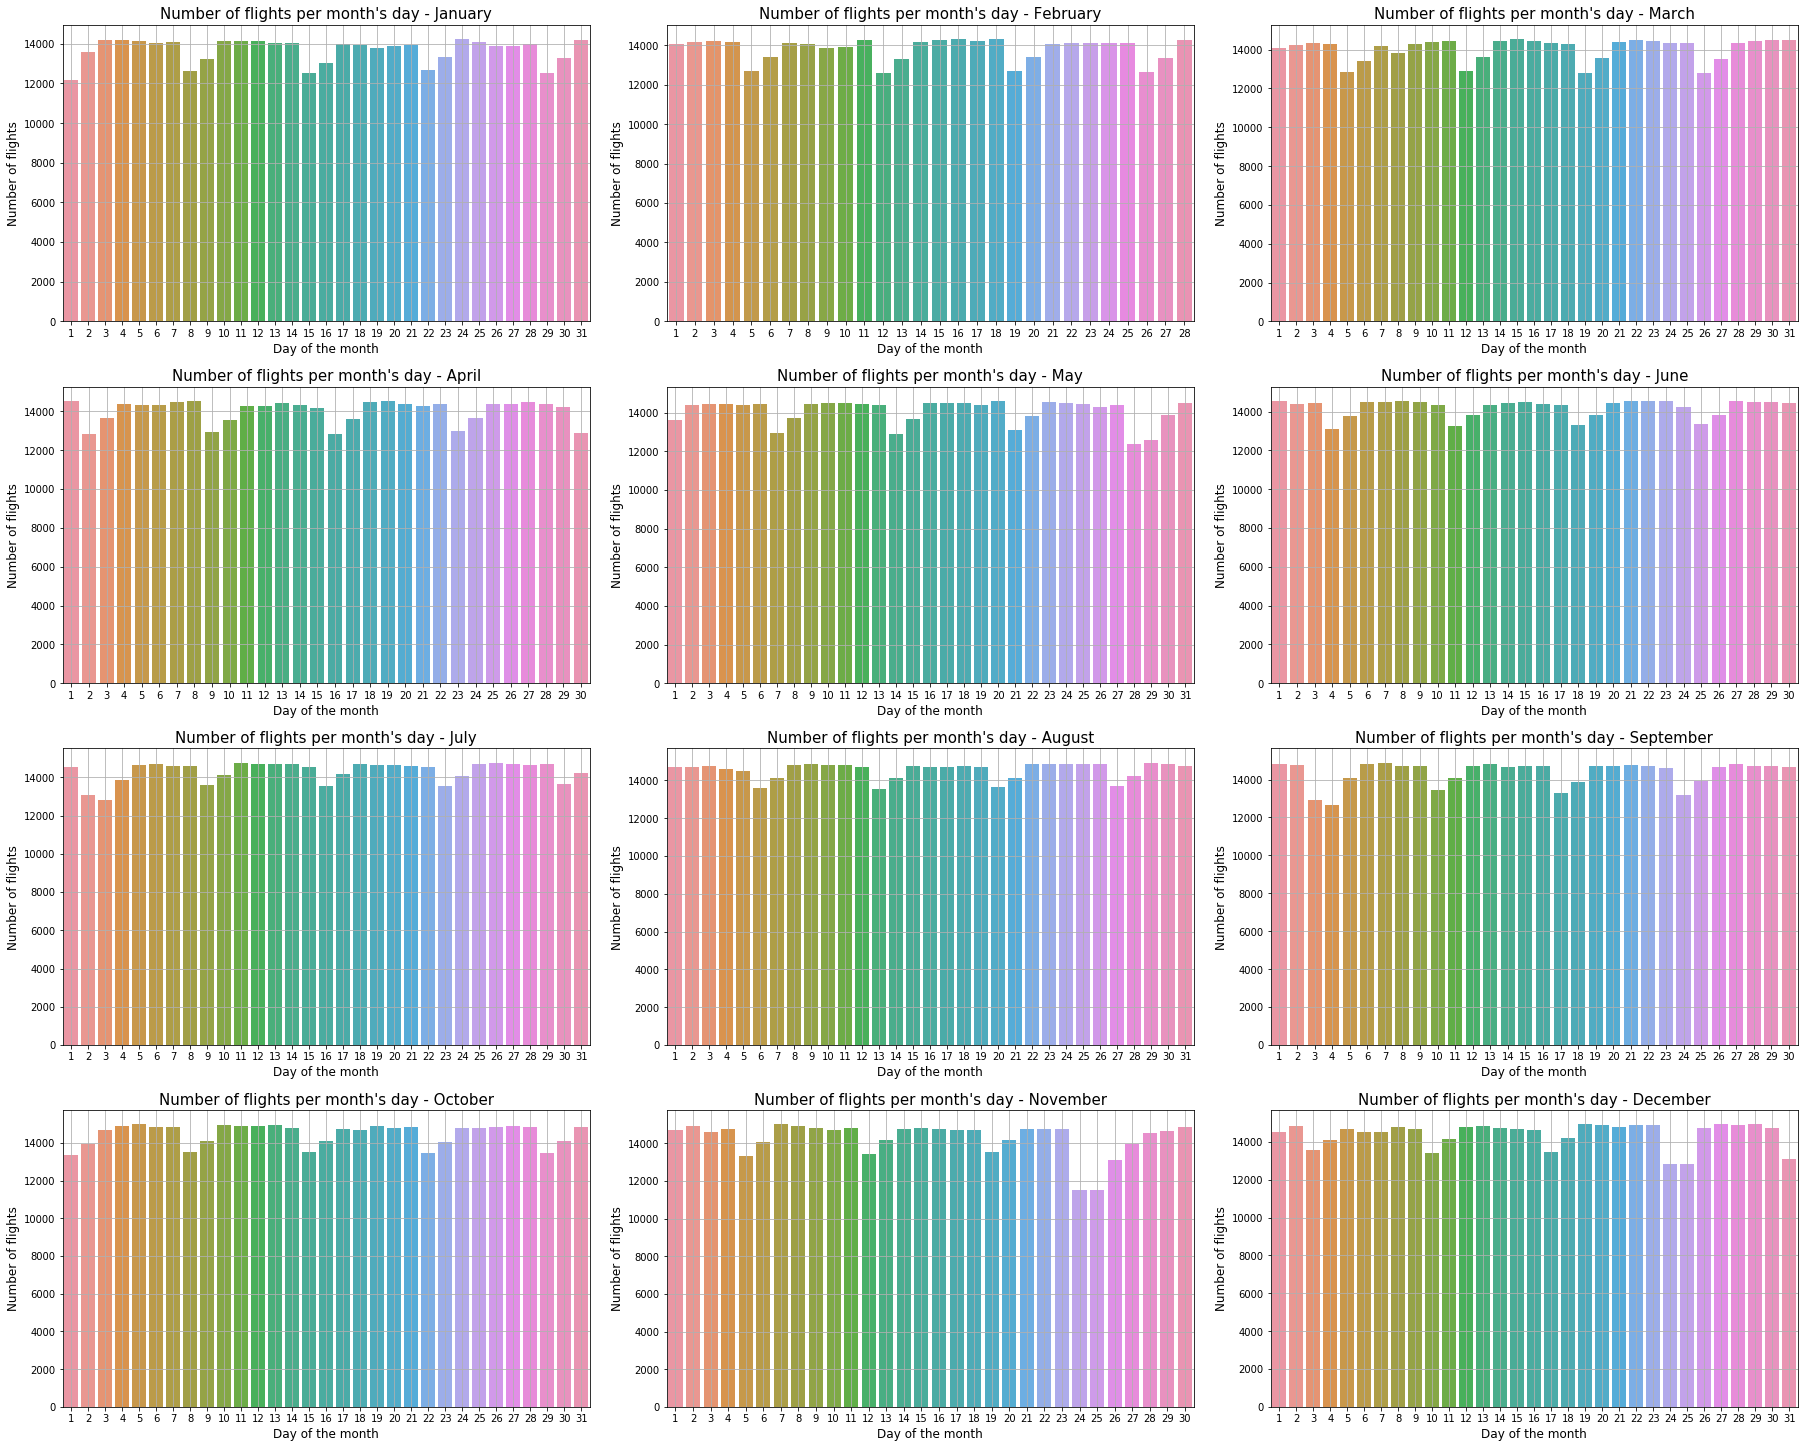

In [25]:
# Now we will consider these data for each month
fig,axes = plt.subplots(4,3, figsize=(25,20))
for x in range(4):
    for y in range(3):
        monthday_numberFlights_pandas_df = df.filter(f"month=={3*x + y + 1}").groupBy("day_of_month").count().sort("day_of_month").toPandas()
        sns.barplot(ax=axes[x,y], x="day_of_month", y="count", data=monthday_numberFlights_pandas_df)
        axes[x,y].grid()
        axes[x,y].set_title(f"Number of flights per month's day - {index_month[3*x + y + 1]}", fontsize=15)
        axes[x,y].set_xlabel("Day of the month", fontsize=12)
        axes[x,y].set_ylabel("Number of flights", fontsize=12)

Here I plot barplots only because I think that values are different enough to let us understand patterns (while before I preferred have a closer look to first 28 days since all the values were very similar and the focus was more on the overall situation. Here instead I think the general pattern between months is more important, but in case we could plot a lineplot as before to see small differences in each month).

From these charts we can see that there is a decrease in the number of flights every 7 days (in particular, on the weekends); this is consistent with what we found before and so that in general the number of flights during the weekends is lower. Of course every month has different values, but the general pattern is similar from month to month.

## Hours of the day

In [26]:
# I decided to convert each time by taking the hour only (for instance if I have 1834 as time I would label it as hour 18)
from math import modf
def convertHour(time):
    _ , hour = modf(time / 100)
    if hour == 24:  # I convert the 24:00 as the hour 0
        hour = 0
    return int(hour)
    
hourUDF = udf(lambda time : convertHour(time))

In [27]:
# Now, we will inspect the data irrespectively of the month of the year
# I assume that by "hour" you mean departure time only
dayhour_numberFlights_df = df.select(hourUDF(col("scheduled_departure_time")).alias("hour")).groupBy("hour").count().withColumnRenamed("count","number_of_flights")
dayhour_numberFlights_df = dayhour_numberFlights_df.withColumn("hour",dayhour_numberFlights_df["hour"].cast(IntegerType())).sort("hour")
dayhour_numberFlights_df.show(24)

+----+-----------------+
|hour|number_of_flights|
+----+-----------------+
|   0|            13642|
|   1|            12825|
|   2|             2842|
|   3|              564|
|   4|              486|
|   5|            13357|
|   6|           257486|
|   7|           398796|
|   8|           397060|
|   9|           341597|
|  10|           300375|
|  11|           313577|
|  12|           356830|
|  13|           360762|
|  14|           294214|
|  15|           313131|
|  16|           317809|
|  17|           368695|
|  18|           338147|
|  19|           287033|
|  20|           232898|
|  21|           168138|
|  22|            52395|
|  23|            37389|
+----+-----------------+



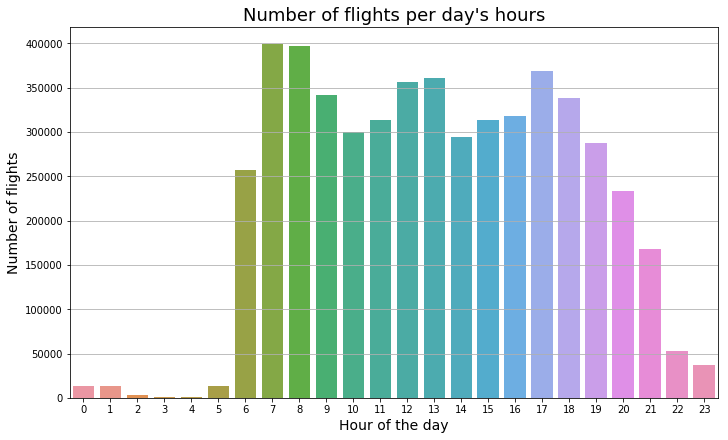

In [28]:
# Plot it
dayhour_numberFlights_pandas_df = dayhour_numberFlights_df.toPandas()
plt.figure(figsize=(10,6))
plt.title("Number of flights per day's hours", fontsize=18)
plt.grid()
sns.barplot(x="hour", y="number_of_flights", data=dayhour_numberFlights_pandas_df)
plt.xlabel("Hour of the day", fontsize=14)
plt.ylabel("Number of flights", fontsize=14)
plt.show()

From this chart is clear how the most active period for flights (in terms of hours) is between 6AM and 9PM. This is reasonable since lower values are associated with night's hours where people are less used to take planes (and also there are less people working in the airports and airlines companies, so less flights)

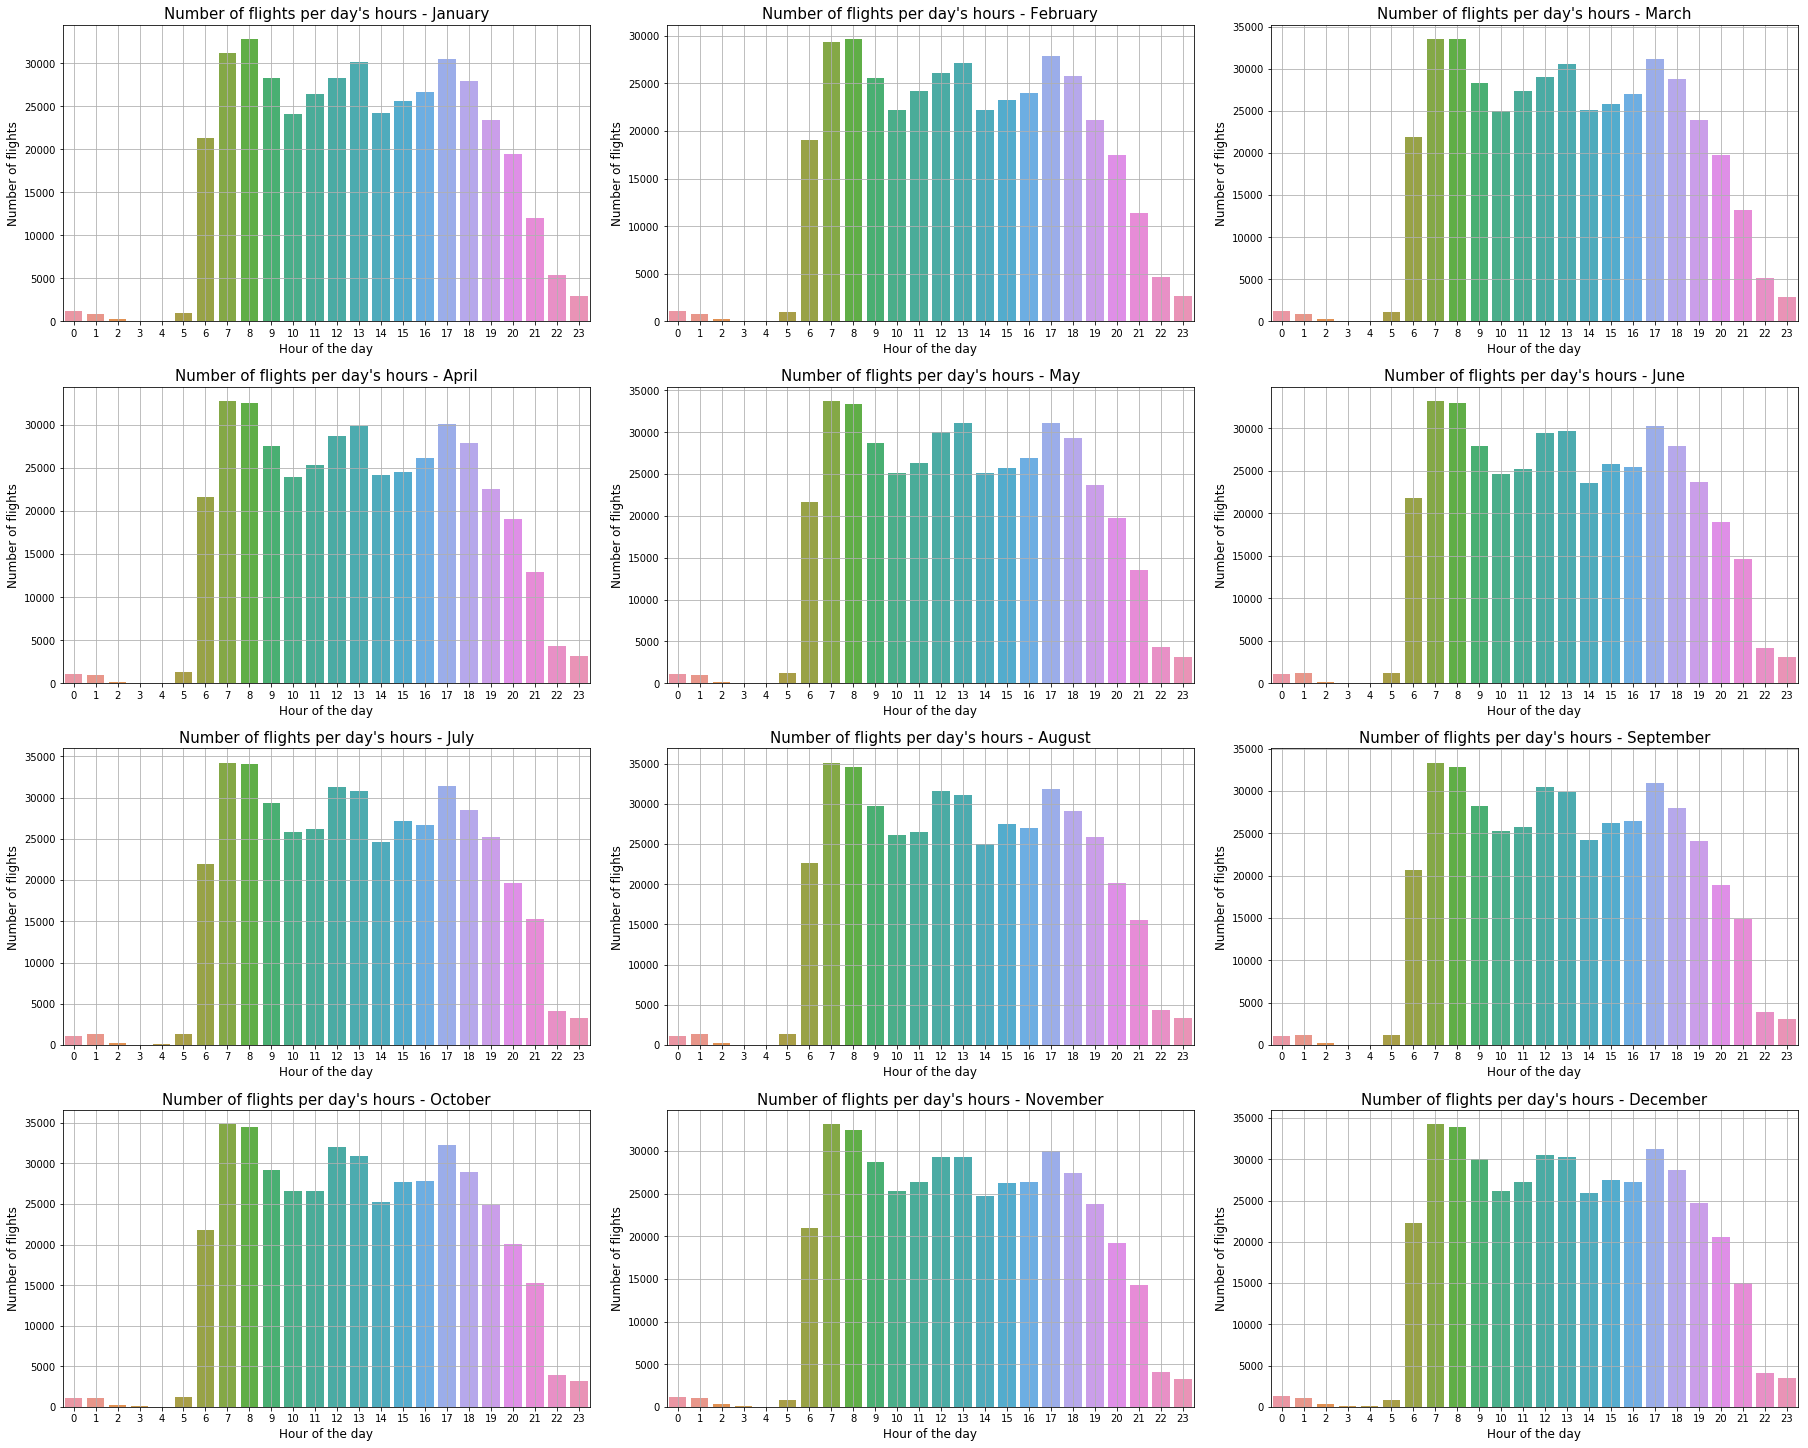

In [29]:
# Now we will consider these data for each month
fig,axes = plt.subplots(4,3, figsize=(25,20))
for x in range(4):
    for y in range(3):
        dayhour_numberFlights_month_df = df.filter(f"month=={3*x + y + 1}").select(hourUDF(col("scheduled_departure_time")).alias("hour"))\
                                            .groupBy("hour").count().withColumnRenamed("count","number_of_flights")
        dayhour_numberFlights_pandas_df = dayhour_numberFlights_month_df.withColumn("hour",dayhour_numberFlights_month_df["hour"].cast(IntegerType())).sort("hour").toPandas()
        sns.barplot(ax=axes[x,y], x="hour", y="number_of_flights", data=dayhour_numberFlights_pandas_df)
        axes[x,y].grid()
        axes[x,y].set_title(f"Number of flights per day's hours - {index_month[3*x + y + 1]}", fontsize=15)
        axes[x,y].set_xlabel("Hour of the day", fontsize=12)
        axes[x,y].set_ylabel("Number of flights", fontsize=12)

These charts show us that the general trend that we observed before is true also looking specifically at each month. We can safely say that the majority of the flights is between 6AM and 9PM, then there is a couple of hours (10PM and 11PM) with a small amount of flights and then between midnight and 5AM there is a very little amount of flights.

### Question 3.4

<div class="alert alert-info">
Which are the **top 20** busiest airports? Compute this in terms of the inbound, outbound and total number of flights.
</div>

In [30]:
# Top 20 inbound busiest airports
df.groupBy("dest_airport").count().sort("count", ascending=False).withColumnRenamed("count","flights").show(20)

+------------+-------+
|dest_airport|flights|
+------------+-------+
|         ORD| 283720|
|         DFW| 260249|
|         ATL| 221588|
|         LAX| 152959|
|         STL| 152800|
|         DEN| 144099|
|         PHX| 140979|
|         DTW| 139435|
|         PIT| 131962|
|         CLT| 130321|
|         MSP| 124758|
|         SFO| 117245|
|         EWR| 117223|
|         IAH| 104409|
|         LGA| 101498|
|         BOS|  99331|
|         LAS|  94948|
|         PHL|  93312|
|         DCA|  87670|
|         MCO|  76600|
+------------+-------+
only showing top 20 rows



In [31]:
# Top 20 outbound busiest airports
df.groupBy("src_airport").count().sort("count", ascending=False).withColumnRenamed("count","flights").show(20)

+-----------+-------+
|src_airport|flights|
+-----------+-------+
|        ORD| 277741|
|        DFW| 256274|
|        ATL| 221486|
|        LAX| 153494|
|        STL| 151609|
|        DEN| 141427|
|        PHX| 139581|
|        DTW| 136837|
|        PIT| 130977|
|        CLT| 129391|
|        MSP| 123222|
|        SFO| 118233|
|        EWR| 116768|
|        IAH| 104182|
|        LGA| 101864|
|        BOS| 100365|
|        LAS|  94972|
|        PHL|  93585|
|        DCA|  88445|
|        MCO|  77120|
+-----------+-------+
only showing top 20 rows



In [32]:
# Top 20 busiest airports
tot_airports = df.groupBy("src_airport").count().union(df.groupBy("dest_airport").count()).withColumnRenamed("src_airport", "airport")
top20Air_flights_df = tot_airports.groupBy("airport").sum("count").withColumnRenamed("sum(count)", "tot_flights").sort("tot_flights", ascending=False).limit(20).cache()
top20Air_flights_df.show()

+-------+-----------+
|airport|tot_flights|
+-------+-----------+
|    ORD|     561461|
|    DFW|     516523|
|    ATL|     443074|
|    LAX|     306453|
|    STL|     304409|
|    DEN|     285526|
|    PHX|     280560|
|    DTW|     276272|
|    PIT|     262939|
|    CLT|     259712|
|    MSP|     247980|
|    SFO|     235478|
|    EWR|     233991|
|    IAH|     208591|
|    LGA|     203362|
|    BOS|     199696|
|    LAS|     189920|
|    PHL|     186897|
|    DCA|     176115|
|    MCO|     153720|
+-------+-----------+



### Question 3.5
<div class="alert alert-info">
Which are the **top 20** busiest carriers? Compute this in terms of number of flights.
</div>


In [33]:
top20carrier_flights_df = df.groupBy("carrier").count().withColumnRenamed("count", "tot_flights").sort("tot_flights", ascending=False).limit(20).cache()
top20carrier_flights_df.show()  # note: there are only 10 carriers in this dataset

+-------+-----------+
|carrier|tot_flights|
+-------+-----------+
|     DL|     874526|
|     US|     857906|
|     AA|     722277|
|     UA|     638750|
|     WN|     565426|
|     CO|     484834|
|     NW|     482798|
|     TW|     258205|
|     HP|     177851|
|     AS|     117475|
+-------+-----------+



## Question 4 
In this series of questions we focus on the computation of statistics about the percentage of delayed flights.

### Question 4.1
<div class="alert alert-info">
What is the percentage of delayed flights for different hours of the day?  

Plot a bar chart and interpret the figure.  


<div class="label label-success">IMPORTANT!</div> A flight is considered as delayed if it's actual arrival time is more than 15 minutes later than the scheduled arrival time.

</div>

In [34]:
# I obtain a dataframe with delayed flights only, and I map the hour
delayed_flights_df = df.filter("arrival_delay > 15").cache()
hour_delayed_flights_df = delayed_flights_df.select(hourUDF(col("scheduled_departure_time")).alias("hour")).cache()
total_delayed_flights = hour_delayed_flights_df.count()
dayhour_numberDelFlights_df = hour_delayed_flights_df.groupBy("hour").count().withColumnRenamed("count", "tot_del_flights")
dayhour_numberDelFlights_numFli_df = dayhour_numberDelFlights_df.join(dayhour_numberFlights_df,["hour"]).sort("hour")
dayhour_percDelFlights_df = dayhour_numberDelFlights_numFli_df.selectExpr("hour","tot_del_flights / number_of_flights * 100 as perc_del_flights")
dayhour_percDelFlights_df = dayhour_percDelFlights_df.withColumn("hour",dayhour_percDelFlights_df["hour"].cast(IntegerType())).sort("hour")
dayhour_percDelFlights_df.show(24)

+----+------------------+
|hour|  perc_del_flights|
+----+------------------+
|   0|15.862776718956164|
|   1|13.668615984405458|
|   2|5.1020408163265305|
|   3|1.0638297872340425|
|   4| 4.732510288065844|
|   5| 5.263157894736842|
|   6| 7.340593274974173|
|   7| 9.684650798904704|
|   8|12.345237495592604|
|   9| 13.67605687403578|
|  10|12.563628797336662|
|  11|13.746862812004707|
|  12|14.703079897990639|
|  13|  15.6945576307926|
|  14|16.162725091260103|
|  15|18.742315516509063|
|  16| 19.49630123753575|
|  17| 21.70683084934702|
|  18| 21.15854938828379|
|  19| 22.03230987377758|
|  20|20.312754939930784|
|  21|19.044475371421093|
|  22|18.326176161847503|
|  23|15.862954344860789|
+----+------------------+



In [35]:
list_hour = dayhour_percDelFlights_df.select("hour").rdd.flatMap(lambda x: x).collect()
list_delay_ratio = dayhour_percDelFlights_df.selectExpr("perc_del_flights / 100").rdd.flatMap(lambda x: x).collect()
pdf_delay_ratio_per_hour = [list_hour, list_delay_ratio]

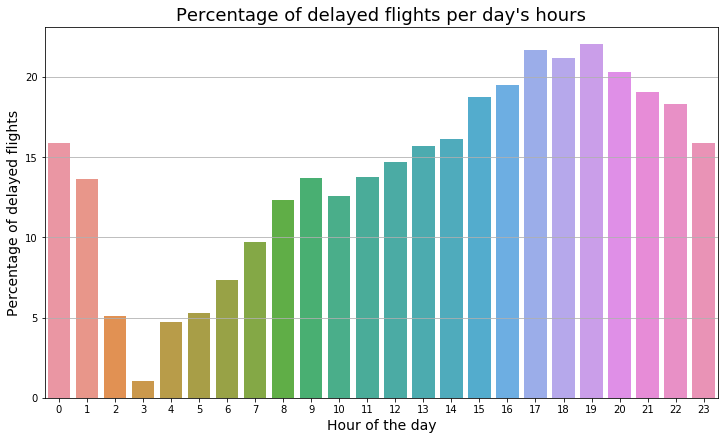

In [36]:
# Plot it
dayhour_percDelFlights_pandas_df = dayhour_percDelFlights_df.toPandas()
plt.figure(figsize=(10,6))
plt.title("Percentage of delayed flights per day's hours", fontsize=18)
plt.grid()
sns.barplot(x="hour", y="perc_del_flights", data=dayhour_percDelFlights_pandas_df)
plt.xlabel("Hour of the day", fontsize=14)
plt.ylabel("Percentage of delayed flights", fontsize=14)
plt.show()

We can notice how the peak is at 7PM; it is a reasonable result since it's a time period where there a lot of flights that already departed (as we saw before, traffic is pretty active since 6AM). Before the deep night the percentage starts decreasing since the number of flights will decrease very much during the night (so there is less traffic) and so the percentage of delayed flights with respect to the total number of delayed flights will inevitably decrease.

### Question 4.2
<div class="alert alert-info">
You will realize that saying *"at 4 A.M. there is a very low chance of a flight being delayed"* is not giving you a full picture of the situation. Indeed, it might be true that there is very little probability for an early flight to be delayed, but if it does, the delay might be huge, like 6 hours!  

<ul></ul>

Then, the question is: **which hours of the day are characterized by the largest mean delay?** (you can consider the median too)  

Plot a Bar chart and explain it.  

</div>

With data of year 1994, the flight from 3AM to 4AM often depart earlier than in their schedule. The flights in the morning have less delay then in the afternoon and evening.

So, an attentive student should notice here that we have somehow a problem with the definition of delay! Next, we will improve how to represent and visualize data to overcome this problem.

**NOTE**: the following piece of code assumes you correctly answered the previous questions. The naming convention of the DataFrames we use next should be clear enough for you to produce them by answering the questions above.

In [37]:
# Mean delay per hour
mean_delay_per_hour_df = df.select("arrival_delay", hourUDF(col("scheduled_departure_time")).alias("hour"))\
                        .groupBy("hour").avg("arrival_delay").withColumnRenamed("avg(arrival_delay)","mean_arr_delay")
mean_delay_per_hour_df = mean_delay_per_hour_df.withColumn("hour",mean_delay_per_hour_df["hour"].cast(IntegerType())).sort("hour")
mean_delay_per_hour_df.show(24)

+----+-------------------+
|hour|     mean_arr_delay|
+----+-------------------+
|   0|  4.631536068730559|
|   1| 2.7302062017944277|
|   2|-2.7850566572237963|
|   3|-2.7652329749103943|
|   4|0.29583333333333334|
|   5|0.26633813495072023|
|   6| 0.6106762748130248|
|   7| 1.7366349096338727|
|   8|  2.807898359028414|
|   9| 3.4053052919247278|
|  10|   3.44393544676388|
|  11|  4.090233343140837|
|  12|  4.496245367107028|
|  13|  5.230250273257823|
|  14|  5.889517094356155|
|  15|  7.594280213778955|
|  16|  8.184353093179144|
|  17|  9.476074194526362|
|  18|  9.354247292912708|
|  19|  9.966784652413988|
|  20|   9.37741762294903|
|  21|  8.009348556401951|
|  22|  7.058168484029721|
|  23|  4.656515715411154|
+----+-------------------+



In [38]:
list_hour = mean_delay_per_hour_df.select("hour").rdd.flatMap(lambda x: x).collect()
list_mean_arr_delay = mean_delay_per_hour_df.select("mean_arr_delay").rdd.flatMap(lambda x: x).collect()
pdf_mean_delay_per_hour = [list_hour, list_mean_arr_delay]

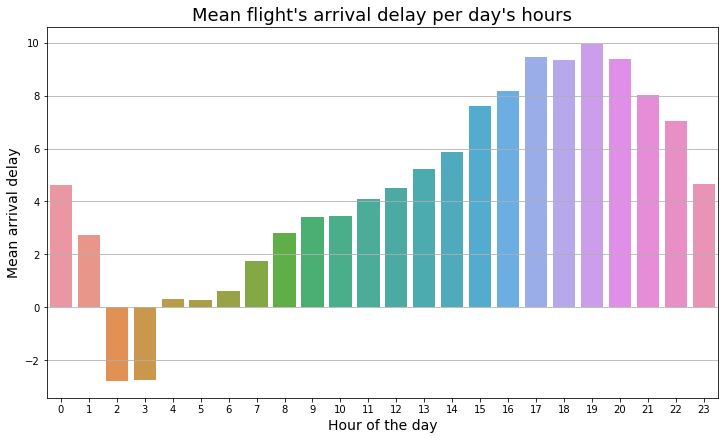

In [39]:
# Plot it
mean_delay_per_hour_pandas_df = mean_delay_per_hour_df.toPandas()
plt.figure(figsize=(10,6))
plt.title("Mean flight's arrival delay per day's hours", fontsize=18)
plt.grid()
sns.barplot(x="hour", y="mean_arr_delay", data=mean_delay_per_hour_pandas_df)
plt.xlabel("Hour of the day", fontsize=14)
plt.ylabel("Mean arrival delay", fontsize=14)
plt.show()

From this chart we can see how the highest mean delay is at 7PM and in general is high during the afternoon and the evening (from 3PM to 10PM). Another important data to point out is the fact that at 2AM and 3AM planes arrived at destination before than the scheduled time (on average).

In [40]:
# Median delay per hour
arrDelay_hour_df = df.select("arrival_delay", hourUDF(col("scheduled_departure_time")).alias("hour"))
arrDelay_hour_df.createOrReplaceTempView("arrDelay_hour_table")
median_delay_per_hour_df = sqlContext.sql("select hour, percentile(arrival_delay, 0.5) as median from arrDelay_hour_table group by hour")
median_delay_per_hour_df = median_delay_per_hour_df.withColumn("hour",median_delay_per_hour_df["hour"].cast(IntegerType())).sort("hour")
median_delay_per_hour_df.show(24)

+----+------+
|hour|median|
+----+------+
|   0|   1.0|
|   1|   0.0|
|   2|  -4.0|
|   3|  -3.0|
|   4|  -1.0|
|   5|  -1.0|
|   6|  -1.0|
|   7|  -1.0|
|   8|   0.0|
|   9|   0.0|
|  10|   0.0|
|  11|   0.0|
|  12|   0.0|
|  13|   1.0|
|  14|   1.0|
|  15|   2.0|
|  16|   2.0|
|  17|   2.0|
|  18|   2.0|
|  19|   2.0|
|  20|   1.0|
|  21|   1.0|
|  22|   2.0|
|  23|   1.0|
+----+------+



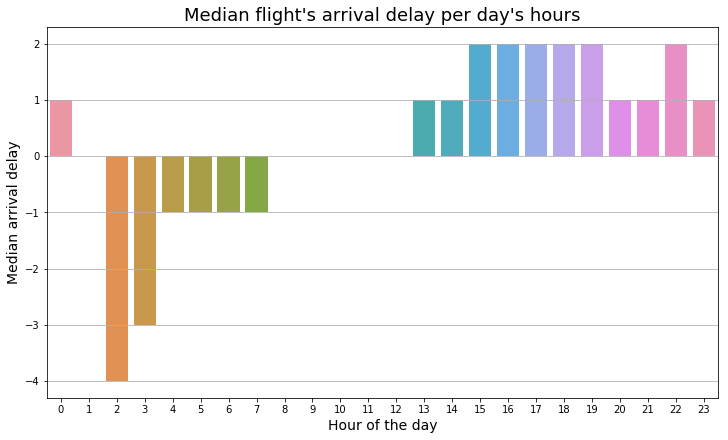

In [41]:
# Plot it
median_delay_per_hour_pandas_df = median_delay_per_hour_df.toPandas()
plt.figure(figsize=(10,6))
plt.title("Median flight's arrival delay per day's hours", fontsize=18)
plt.grid()
sns.barplot(x="hour", y="median", data=median_delay_per_hour_pandas_df)
plt.xlabel("Hour of the day", fontsize=14)
plt.ylabel("Median arrival delay", fontsize=14)
plt.show()

Median delays distribution has a very different shape to mean delays distribution. Here we can notice how the highest values are in the afternoon and evening (as it was for the mean) and lower values are during all the early morning.

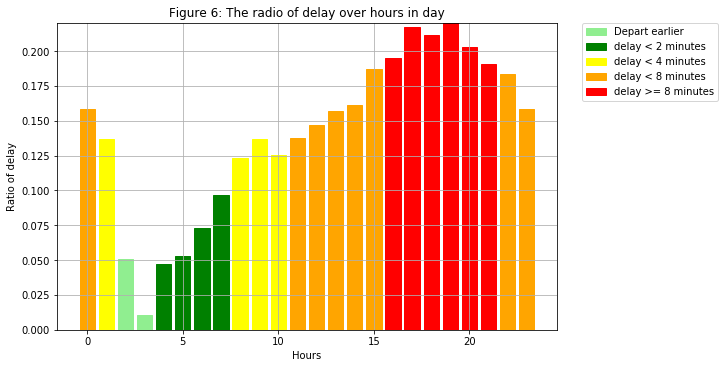

In [42]:
#pdf2 = pd.DataFrame(data=mean_delay_per_hour.collect())
plt.figure(figsize=(10,5))
plt.xlabel("Hours")
plt.ylabel("Ratio of delay")
plt.title('Figure 6: The radio of delay over hours in day')
plt.grid(True,which="both",ls="-")
bars = plt.bar(pdf_delay_ratio_per_hour[0], pdf_delay_ratio_per_hour[1], align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'red'
    if pdf_mean_delay_per_hour[1][i] < 0:
        color = 'lightgreen'
    elif pdf_mean_delay_per_hour[1][i] < 2:
        color = 'green'
    elif pdf_mean_delay_per_hour[1][i] < 4:
        color = 'yellow'
    elif pdf_mean_delay_per_hour[1][i] < 8:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='Depart earlier')
patch2 = mpatches.Patch(color='green', label='delay < 2 minutes')
patch3 = mpatches.Patch(color='yellow', label='delay < 4 minutes')
patch4 = mpatches.Patch(color='orange', label='delay < 8 minutes')
patch5 = mpatches.Patch(color='red', label='delay >= 8 minutes')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.margins(0.05, 0)
plt.show()

In the new figure (Figure 6), we have more information in a single plot. The flights in 3AM to 4AM have very low probability of being delayed, and actually depart earlier than their schedule. In contrast, the flights in the 4PM to 8PM range have higher chances of being delayed: in more than 50% of the cases, the delay is 8 minutes or more.

This example shows us that the way representing results are also important.


### Question 4.3

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a month. Discuss your findings from the figure.
</div>

In [43]:
monthday_numDelFlights_df = df.filter("arrival_delay > 15").groupBy("day_of_month").count().withColumnRenamed("count", "tot_del_flights")
# dataframe with day of the month, number of delayed flights, number of flights
monthday_numDelFli_numFli_df = monthday_numberFlights_df.join(monthday_numDelFlights_df,["day_of_month"]).sort("day_of_month").withColumnRenamed("count","tot_flights")
# monthday_numDelFli_numFli_df.show(31)

In [44]:
# dataframe with day of the month, percentage of delayed flights
monthday_percDelFli_df = monthday_numDelFli_numFli_df.selectExpr("day_of_month","tot_del_flights / flights * 100 as perc_del_flights")
monthday_percDelFli_df.show(31)

+------------+------------------+
|day_of_month|  perc_del_flights|
+------------+------------------+
|           1|13.808833409950847|
|           2| 14.02292894617527|
|           3| 13.83167929427667|
|           4| 13.44281843458344|
|           5| 15.95744049209431|
|           6|15.297978318195135|
|           7| 15.54613553219906|
|           8|15.663194159625954|
|           9| 17.74431580989787|
|          10| 17.08408711791932|
|          11| 13.77797890486302|
|          12| 15.75420839673945|
|          13|16.658295859370437|
|          14|15.760601112266897|
|          15| 16.39539174285597|
|          16| 16.34732476394976|
|          17| 15.84005360543578|
|          18|16.279353922777943|
|          19| 13.54413126980287|
|          20| 16.48221944350306|
|          21| 17.82648317013286|
|          22| 16.60663728437582|
|          23|16.571077067283753|
|          24| 15.12991423196437|
|          25|15.889151013826261|
|          26|18.556352841491524|
|          27|

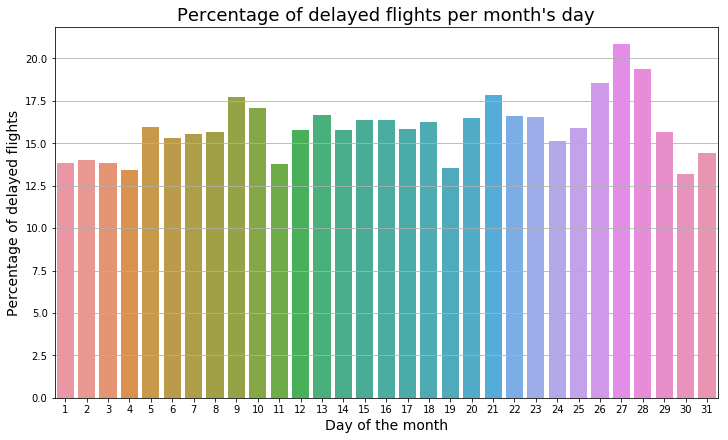

In [45]:
# Plot it
monthday_percDelFlights_pandas_df = monthday_percDelFli_df.toPandas()
plt.figure(figsize=(10,6))
plt.title("Percentage of delayed flights per month's day", fontsize=18)
plt.grid()
sns.barplot(x="day_of_month", y="perc_del_flights", data=monthday_percDelFlights_pandas_df)
plt.xlabel("Day of the month", fontsize=14)
plt.ylabel("Percentage of delayed flights", fontsize=14)
plt.show()

From the chart we can notice that the percentage of delayed flights is greater than 12.5% for all the month's day. The peak is at the 27th day of the month.

### Question 4.4

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a week. Discuss your findings from the figure.
</div>

In [46]:
weekday_numDelFlights_df = df.filter("arrival_delay > 15").groupBy("day_of_week").count().withColumnRenamed("count", "tot_del_flights")
# dataframe with day of the week, number of delayed flights, number of flights
weekday_numDelFli_numFli_df = weekday_numDelFlights_df.join(weekday_numberFlights_df,["day_of_week"]).sort("day_of_week").withColumnRenamed("count","tot_flights")
# weekday_numDelFli_numFli_df.show(7)

In [47]:
# dataframe with day of the week, percentage of delayed flights
weekday_percDelFli_df = weekday_numDelFli_numFli_df.selectExpr("day_of_week","tot_del_flights / flights * 100 as perc_del_flights")
weekday_percDelFli_df.show(7)

+-----------+------------------+
|day_of_week|  perc_del_flights|
+-----------+------------------+
|          1|15.335207967814945|
|          2|14.322593095863756|
|          3| 17.06436030779638|
|          4|18.594826335895636|
|          5|18.277090366199133|
|          6| 13.18988270321973|
|          7|14.547227628299167|
+-----------+------------------+



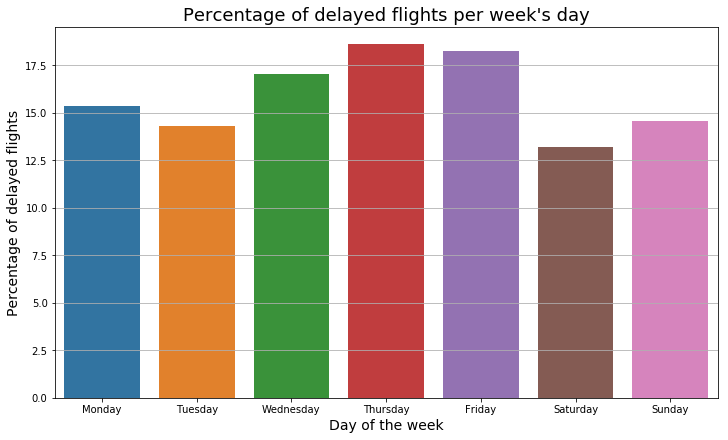

In [48]:
# Plot it
weekday_percDelFlights_pandas_df = weekday_percDelFli_df.toPandas()
weekday_percDelFlights_pandas_df.replace({"day_of_week": index_day_of_week}, inplace=True)
plt.figure(figsize=(10,6))
plt.title("Percentage of delayed flights per week's day", fontsize=18)
plt.grid()
sns.barplot(x="day_of_week", y="perc_del_flights", data=weekday_percDelFlights_pandas_df)
plt.xlabel("Day of the week", fontsize=14)
plt.ylabel("Percentage of delayed flights", fontsize=14)
plt.show()

Again, the percentage of delayed flights is greater than 12.5% for all the weekdays. Looking at the bars, the days on which there are more delayed flights are Thursday and Friday.

### Question 4.5
<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over months in a year. Discuss your findings from the figure.
</div>

We are ready now to draw some observations from our data, even if we have only looked at data coming from a year worth of flights:

- The probability for a flight to be delayed is low at the beginning or at the very end of a given months
- Flights on two first weekdays and on the weekend, are less likely to be delayed
- May and September are very good months for travelling, as the probability of delay is low (remember we're working on US data. Do you think this is also true in France?)

Putting things together, we can have a global picture of the whole year!

In [49]:
month_numDelFlights_df = df.filter("arrival_delay > 15").groupBy("month").count().withColumnRenamed("count", "tot_del_flights")
# dataframe with month, number of delayed flights, number of flights
month_numDelFli_numFli_df = month_numDelFlights_df.join(month_flights_df,["month"]).sort("month").withColumnRenamed("count","tot_flights")
# month_numDelFli_numFli_df.show(12)

In [50]:
# dataframe with month, percentage of delayed flights
month_percDelFli_df = month_numDelFli_numFli_df.selectExpr("month","tot_del_flights / flights * 100 as perc_del_flights")
month_percDelFli_df.show(12)

+-----+------------------+
|month|  perc_del_flights|
+-----+------------------+
|    1|23.110642403995648|
|    2|20.312491924104677|
|    3|14.984524104740125|
|    4|15.198755329635743|
|    5|10.893335044176412|
|    6|16.198269596004597|
|    7|  18.2590549335641|
|    8|14.385948577433128|
|    9|10.581138696702649|
|   10|12.439887931744291|
|   11|  17.2681778589393|
|   12|18.382786027980767|
+-----+------------------+



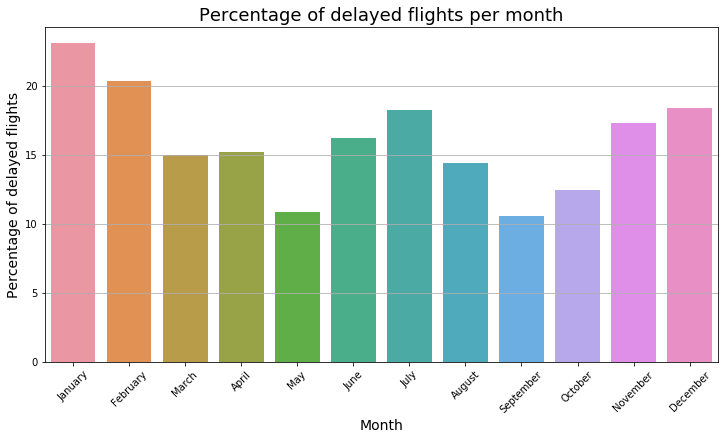

In [51]:
# Plot it
month_percDelFli_pandas_df = month_percDelFli_df.toPandas()
month_percDelFli_pandas_df.replace({"month": index_month}, inplace=True)
plt.figure(figsize=(10,6))
plt.title("Percentage of delayed flights per month", fontsize=18)
plt.grid()
sns.barplot(x="month", y="perc_del_flights", data=month_percDelFli_pandas_df)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Percentage of delayed flights", fontsize=14)
plt.xticks(rotation=45)
plt.show()

From the chart we can see that the highest percentages of delayed flights are in January, February, July and December. This is reasonable if we think that during summer the traffic may be more heavy and that during winter the weather situation can cause delays.

In [52]:
from pyspark.sql.functions import when

df_with_delay = df.withColumn('is_delay', when(df["arrival_delay"] >= 15, 1).otherwise(0))
statistic_day = df_with_delay.groupBy(['year','month', 'day_of_month', 'day_of_week'])\
    .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))

# assume that we do statistic on year 1994
statistic_day = statistic_day\
    .orderBy('year', 'month', 'day_of_month', 'day_of_week')
pdf = pd.DataFrame(data=statistic_day.collect())

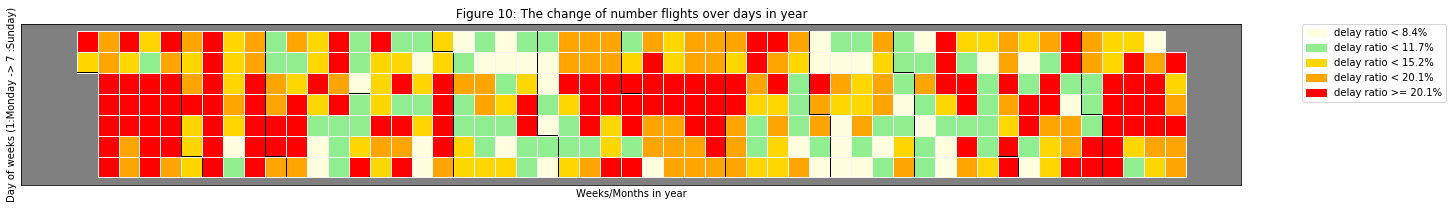

In [53]:
fig = plt.figure(figsize=(20,10))                                                             
ax = fig.add_subplot(1,1,1)     
plt.xlabel("Weeks/Months in year")
plt.ylabel("Day of weeks (1:Monday -> 7 :Sunday)")
plt.title('Figure 10: The change of number flights over days in year')
  
rec_size = 0.3
from matplotlib.patches import Rectangle
import datetime
num_days = len(pdf[0])
ax.patch.set_facecolor('gray')
ax.set_aspect('equal', 'box')
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

for i in range(0, num_days):
    # extract information from the result
    year = pdf[0][i]
    month = pdf[1][i]
    day_of_month = pdf[2][i]
    day_of_week = pdf[3][i]
    day_of_year= datetime.date(year=year, month=month, day=day_of_month).timetuple()
    week_of_year = datetime.date(year=year, month=month, day=day_of_month).isocalendar()[1]
    
    # dealing with the week of the previous year
    if week_of_year == 52 and month == 1:
        week_of_year = 0
        
    # the coordinate of a day in graph
    X = week_of_year*rec_size
    Y = day_of_week*rec_size
    
    # use different colors to show the delay ratio
    color = 'white'
    if pdf[4][i] <= 0.084:
        color = 'lightyellow'
    elif pdf[4][i] <= 0.117:
        color = 'lightgreen'
    elif pdf[4][i] <= 0.152:
        color = 'gold'
    elif pdf[4][i] <= 0.201:
        color = 'orange'
    else:
        color = 'red'
    rect = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, rec_size,
                      alpha=1, facecolor=color, edgecolor='whitesmoke')

    ax.add_patch(rect)
    
    # drawing boders to separate months
    if day_of_month <= 7:
        rect2 = plt.Rectangle((X -rec_size/2.0, Y - rec_size/2.0), 0.01, rec_size,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
    if day_of_month == 1:
        rect2 = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, 0.01,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
ax.autoscale_view()

patch1 = mpatches.Patch(color='lightyellow', label='delay ratio < 8.4%')
patch2 = mpatches.Patch(color='lightgreen', label='delay ratio < 11.7%')
patch3 = mpatches.Patch(color='gold', label='delay ratio < 15.2%')
patch4 = mpatches.Patch(color='orange', label='delay ratio < 20.1%')
patch5 = mpatches.Patch(color='red', label='delay ratio >= 20.1%')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

Thanks to this chart we have a global view over delays in the year. As we discussed before, we can clearly see that the delays are heavy in winter period (last weeks of the year and first weeks of the year) and during summer. During the rest of the year the delay may vary, but in general they are lower as we can see from this chart.

### Question 4.6
<div class="alert alert-info">

What is the delay probability for the top 20 busiest airports?  


By drawing the flight volume of each airport and the associated delay probability in a single plot, we can observe the relationship between airports, number of flights and the delay.  

<div class="label label-success">HINT </div>  Function `<df_colum>.isin(<list>)` helps checking whether a value in column belongs to a list.
<ul></ul>
<div class="label label-success">SUGGESTION </div>  You can try with different chart type to have a better visualization.
</div>

In [54]:
# airport , total delayed flights - I consider both origin and destination airports
src_air_delFlights_df = delayed_flights_df.select("src_airport").groupBy("src_airport").count().withColumnRenamed("count","del_flights").withColumnRenamed("src_airport","airport")
dest_air_delFlights_df = delayed_flights_df.select("dest_airport").groupBy("dest_airport").count().withColumnRenamed("count","del_flights").withColumnRenamed("dest_airport","airport")
air_delFlights_df = src_air_delFlights_df.union(dest_air_delFlights_df).groupBy("airport").sum("del_flights").withColumnRenamed("sum(del_flights)", "del_flights")
# I join it with the top20 busiest airports
top20Air_totFlights_delFlights_df = top20Air_flights_df.join(air_delFlights_df,["airport"],"left")
# dataframe with airport (top20), tot_flights, delay probability
top20Air_totFlights_delayProb_df = top20Air_totFlights_delFlights_df.selectExpr("airport","tot_flights","del_flights / tot_flights as delay_prob").sort("tot_flights",ascending=False)
top20Air_totFlights_delayProb_df.show()

+-------+-----------+-------------------+
|airport|tot_flights|         delay_prob|
+-------+-----------+-------------------+
|    ORD|     561461|0.14670475776590003|
|    DFW|     516523| 0.1914183879517466|
|    ATL|     443074|  0.193574888167665|
|    LAX|     306453|0.17269532358958797|
|    STL|     304409|0.15884878567979266|
|    DEN|     285526|0.18410582573916212|
|    PHX|     280560| 0.1554248645566011|
|    DTW|     276272|0.13957983436613192|
|    PIT|     262939|0.18139948809419676|
|    CLT|     259712| 0.1750246426811237|
|    MSP|     247980|0.13150254052746188|
|    SFO|     235478|0.17388460917792745|
|    EWR|     233991|0.25025748853588387|
|    IAH|     208591|0.15597509000867726|
|    LGA|     203362| 0.1750818737030517|
|    BOS|     199696| 0.2073802179312555|
|    LAS|     189920|0.16055181128896379|
|    PHL|     186897| 0.1918864401247746|
|    DCA|     176115|0.15140107316242227|
|    MCO|     153720| 0.1666471506635441|
+-------+-----------+-------------

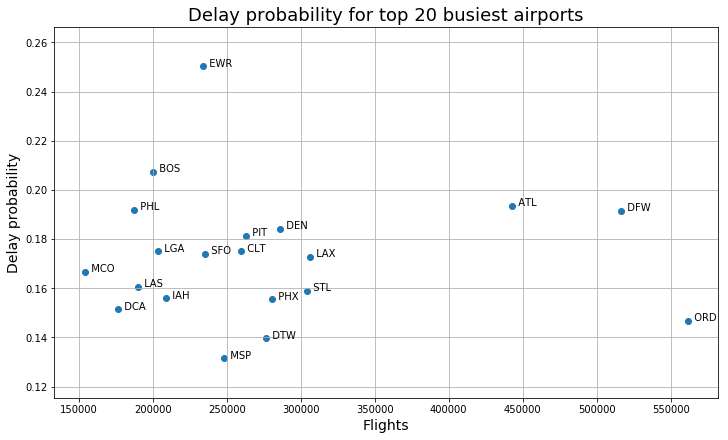

In [55]:
# Plot it
top20Air_totFlights_delayProb_pandas_df = top20Air_totFlights_delayProb_df.toPandas()
x = top20Air_totFlights_delayProb_pandas_df["tot_flights"]
y = top20Air_totFlights_delayProb_pandas_df["delay_prob"]
plt.figure(figsize=(10,6))
plt.title("Delay probability for top 20 busiest airports", fontsize=18)
plt.grid()
plt.scatter(x, y)
top_20_airports_list = top20Air_flights_df.select("airport").rdd.flatMap(lambda x: x).collect()
for i, txt in enumerate(top_20_airports_list):
    plt.annotate("  " + txt, (x[i], y[i]))
plt.xlabel("Flights", fontsize=14)
plt.ylabel("Delay probability", fontsize=14)
plt.show()

In my opinion a scatter plot is the best way to visualize this information. I use direct labeling in the scatterplot to respect general data visualization rules. We can see how EWR airport has the highest delay probability (among the top 20 busiest airports). We have to mention that ORD has a pretty low delay probability and it is able to manage the biggest amount of flights.

### Question 4.7

<div class="alert alert-info">
What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?  
Comment the figure!

<ul></ul>
<div class="label label-success">SUGGESTION </div>  You can try with different chart type to have a better visualization.
</div>

In [56]:
# carrier , total delayed flights
carrier_delFlights_df = delayed_flights_df.select("carrier").groupBy("carrier").count().withColumnRenamed("count","del_flights")
# I join it with the top20 busiest airports
top20Car_totFlights_delFlights_df = top20carrier_flights_df.join(carrier_delFlights_df,["carrier"],"left")
# dataframe with carrier (top20), tot_flights, delay probability
top20Car_percDelFlights_df = top20Car_totFlights_delFlights_df.selectExpr("carrier","del_flights / tot_flights * 100 as perc_del_flights").sort("perc_del_flights",ascending=False)
top20Car_percDelFlights_df.show()

+-------+------------------+
|carrier|  perc_del_flights|
+-------+------------------+
|     CO|18.443632253513574|
|     US| 17.31425121167121|
|     HP|17.262202630291647|
|     TW|17.115470265874013|
|     DL| 16.94415031685736|
|     AA| 16.52966936507739|
|     UA|15.880704500978474|
|     AS|14.394552032347308|
|     NW|12.181284926615271|
|     WN|12.075850774460319|
+-------+------------------+



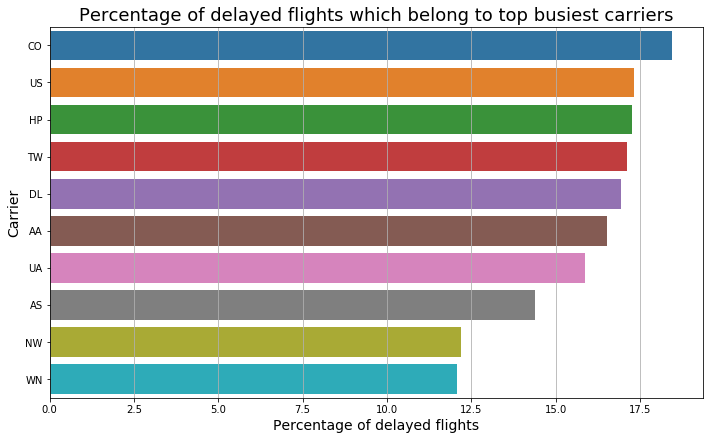

In [57]:
# Plot it
top20Car_percDelFlights_pandas_df = top20Car_percDelFlights_df.toPandas()
plt.figure(figsize=(10,6))
plt.title("Percentage of delayed flights which belong to top busiest carriers", fontsize=18)
plt.grid()
sns.barplot(x="perc_del_flights", y="carrier", data=top20Car_percDelFlights_pandas_df)
plt.xlabel("Percentage of delayed flights", fontsize=14)
plt.ylabel("Carrier", fontsize=14)
plt.show()

I chose this visualization since we can immediately see which are the carriers with the highest number of delayed flights (data visualization motivation: proportions are kept here, so we have a lie factor of 1). We can notice how all the carriers (which are 10 only, so they are all among the "top 20" busiest carriers) have a percentage of delayed flights grater than 12 %

## Addition (bonus) questions

### Additional data
In the HDFS file system you have used for running the Notebook, you will notice that there are several other years available (in addition to 1994).

There are some other datasets that related to this use case:

- Airport IATA Codes to City names and Coordinates mapping: http://stat-computing.org/dataexpo/2009/airports.csv
- Carrier codes to Full name mapping: http://stat-computing.org/dataexpo/2009/carriers.csv
- Information about individual planes: http://stat-computing.org/dataexpo/2009/plane-data.csv
- Weather information: http://www.wunderground.com/weather/api/. You can subscribe for free to the developers' API and obtain (at a limited rate) historical weather information in many different formats. Also, to get an idea of the kind of information is available, you can use this link: http://www.wunderground.com/history/

### Question 5.1

<div class="alert alert-info">

Which airports are present in the dataset only as destination airport?

Which airport is present only as source airport in the dataset? 

</div>

### Question 5.2

<div class="alert alert-info">

Which airports have biggest delay probability ?

Which cities have largest delay duration in average ?

</div>

### Question 5.3

<div class="alert alert-info">

Is there any relationship between weather condition and the delay of flights in 1994 ?

</div>


In [217]:
# Which airports are present in the dataset only as destination airport?
destination_airports_df.join(origin_airports_df,["airport"],"left_anti").show()

+-------+
|airport|
+-------+
|    BFI|
|    GUM|
+-------+



In [219]:
# Which airports are present in the dataset only as source airport?
origin_airports_df.join(destination_airports_df,["airport"],"left_anti").show()

+-------+
|airport|
+-------+
|    SPN|
+-------+

